<a href="https://colab.research.google.com/github/shaanbarca/datascience_portfolio/blob/main/tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!echo '{"username":"shaanbarca","key":"97c14193dc72145e70833ff22b753abd"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d zillow/zecon -f State_time_series.csv

  0% 0.00/1.71M [00:00<?, ?B/s]
100% 1.71M/1.71M [00:00<00:00, 57.2MB/s]


In [ ]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 9.1MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 1.2MB 13.8MB/s 
     |████████████████████████████████| 194kB 46.3MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 12.8MB 29.0MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [ ]:
creds = '{"username":"shaanbarca","key":"97c14193dc72145e70833ff22b753abd"}'

In [ ]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [ ]:
path = URLs.path('bluebook')
path

Path('/root/.fastai/archive/bluebook')

In [ ]:
Path.BASE_PATH = path

In [ ]:
if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

path.ls(file_type='text')

 10%|█         | 5.00M/48.4M [00:00<00:01, 37.1MB/s]

100%|██████████| 48.4M/48.4M [00:01<00:00, 36.6MB/s]


(#7) [Path('Valid.csv'),Path('TrainAndValid.csv'),Path('ValidSolution.csv'),Path('Machine_Appendix.csv'),Path('median_benchmark.csv'),Path('random_forest_benchmark_test.csv'),Path('Test.csv')]

In [ ]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [ ]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [ ]:
#certain columns need to be ordered
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [ ]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [ ]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True) #how to set the order

In [ ]:
dep_var = 'SalePrice'

In [ ]:
df[dep_var] = np.log(df[dep_var])

In [ ]:
df = add_datepart(df, 'saledate')

In [ ]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [ ]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [ ]:
procs = [Categorify, FillMissing]

In [ ]:
#splitting the data
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [ ]:
# we need to split continious from categorical variable
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [ ]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [ ]:
len(to.train),len(to.valid)

(404710, 7988)

In [ ]:
#hide_output
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [ ]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [ ]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [ ]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [ ]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [ ]:
save_pickle(path/'to.pkl',to)

In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

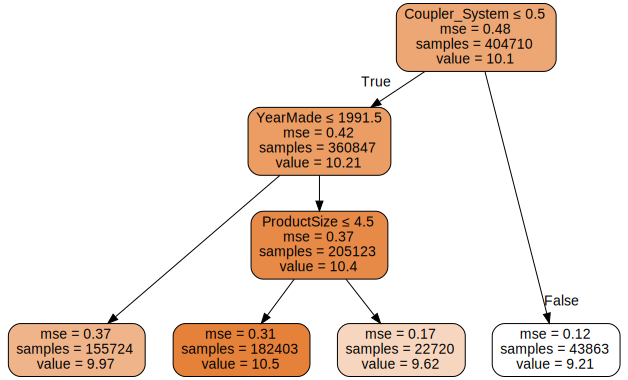

In [ ]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

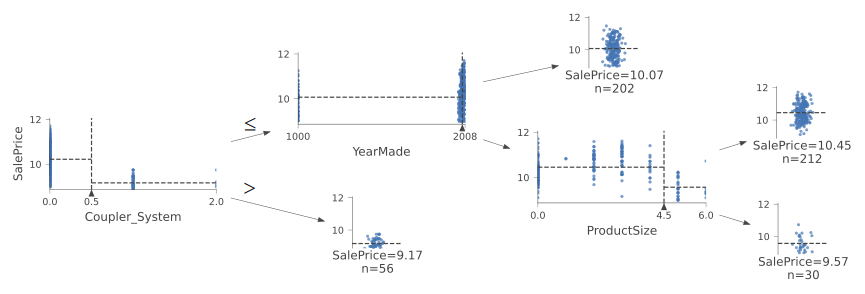

In [ ]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [ ]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

In [ ]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [ ]:
m_rmse(m, xs, y)

1e-06

In [ ]:
m_rmse(m, valid_xs, valid_y)

0.332738

In [ ]:
m.get_n_leaves(), len(xs)

(324556, 404710)

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248562, 0.32334)

In [ ]:
m.get_n_leaves()

12397

In [ ]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
  return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                  max_samples=max_samples, max_features=max_features,
                  min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
m = rf(xs, y);

In [ ]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.17131, 0.233751)

In [ ]:
#same thing
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
r_mse(preds.mean(0), valid_y)

0.233751

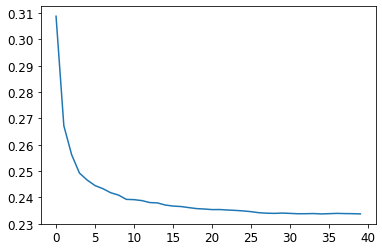

In [ ]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

###OOB Error

Out of bag error is since  each model only uses a sub sample of the data, they all have their own validation sets. Therfore 00B is when each model uses row it does not use for training the model

In [ ]:
r_mse(m.oob_prediction_, y)



0.211211

#### Model Interpretation



1. How confident are we in our prediction using a particular row ?
2. For predicting a particular row what are the most important factors ?
3. Which columns are the strongest predictors
4. Which columns are redundant (Multcollinearity)
5. How do predictions vary as we vary each column



### Tree variance for each prediction

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
preds.shape

(40, 7988)

we want to know the relative confidence of our prediction. How ? by getting the standard deviatioon of prediction of all our trees. We can see we have we have 40 trees and 7988 auction data

In [ ]:
preds_std = preds.std(0)

In [ ]:
preds_std[:5]

array([0.26059707, 0.15800606, 0.11747052, 0.26404597, 0.09747617])

### Feature importance

In [ ]:
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                      ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.179262
30,Coupler_System,0.115879
6,ProductSize,0.115540
7,fiProductClassDesc,0.073954
54,ModelID,0.057249
31,Grouser_Tracks,0.050994
65,saleElapsed,0.050013
3,fiSecondaryDesc,0.041753
12,Enclosure,0.035365
1,fiModelDesc,0.033088


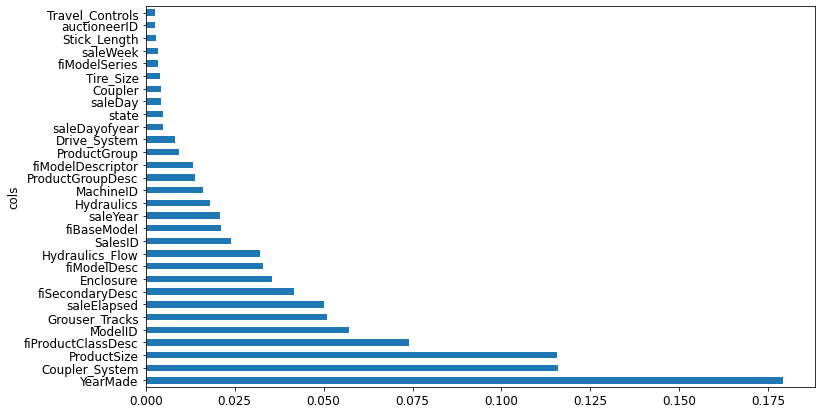

In [ ]:
### plot feature importance

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

feauture importance is calulated by looping each tree and exploring each branch. at each branch it sees what feature was used to split and how much the model imporved as a result of that split. 

improvement, weighted by number of rows in the group is added to importance score of that feature. 
This is summed across all the trees and then score are normalized such that they add to 1

#### We want to remove low importance variables



In [ ]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

20

In [ ]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [ ]:
m = rf(xs_imp, y)

In [ ]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181271, 0.231672)

In [ ]:
len(xs.columns), len(xs_imp.columns)

(66, 20)

its important to reduce columns so we can study each one in depth (when using model that are not N.N)

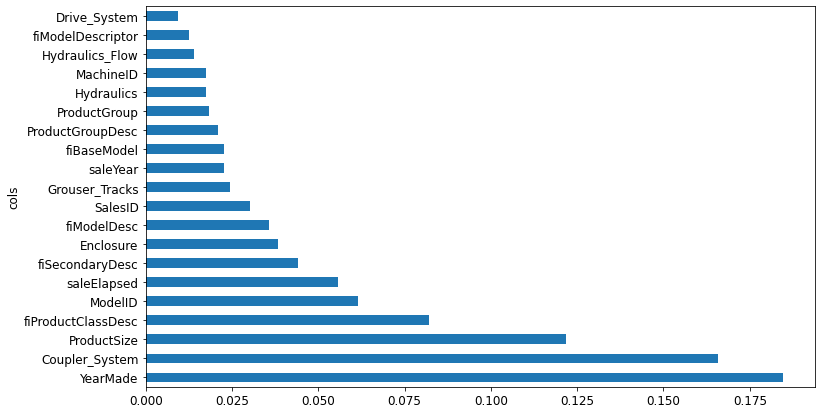

In [ ]:
plot_fi(rf_feat_importance(m, xs_imp));

### removing redundant features

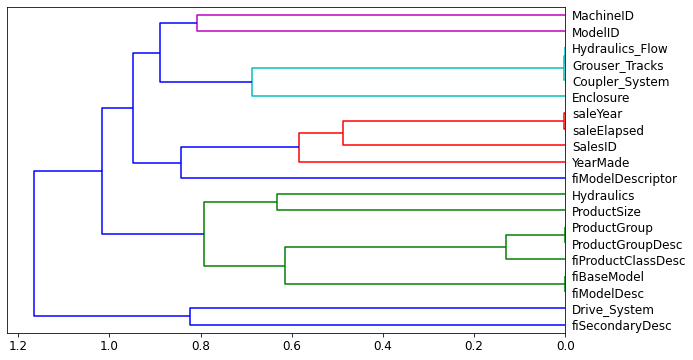

In [ ]:
cluster_columns(xs_imp)

When determing simillarity, simillar pairs are calculated by checking rank correlation. All values are replaced with rank and correlation is then calculated. 



In [ ]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [ ]:
get_oob(xs_imp)

0.8776780914767052

In [ ]:
# we then want to remove each of our pottentianly redundant variables one at a time 

{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'Coupler_System': 0.8768209925362782,
 'Grouser_Tracks': 0.8771309597047973,
 'Hydraulics_Flow': 0.8771063665038368,
 'ProductGroup': 0.8769788832420483,
 'ProductGroupDesc': 0.876969949262272,
 'fiBaseModel': 0.8750485352901528,
 'fiModelDesc': 0.8745280013013863,
 'saleElapsed': 0.8716097899580801,
 'saleYear': 0.8760047520760266}

In [ ]:
#remove the rest of potential redundant columns
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.875270588886242

In [ ]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [ ]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [ ]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.182758, 0.2323)

### partial dependence

([<matplotlib.axis.YTick at 0x7efd06c11290>,
 [Text(0, 0, '#na#'),
  Text(0, 0, 'Large'),
  Text(0, 0, 'Large / Medium'),
  Text(0, 0, 'Medium'),
  Text(0, 0, 'Small'),
  Text(0, 0, 'Mini'),
  Text(0, 0, 'Compact')])

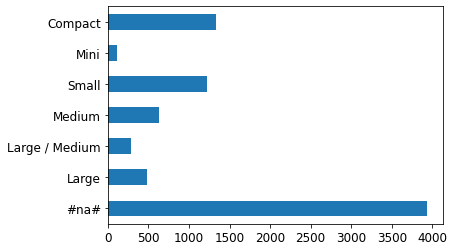

In [ ]:
#important to check the value count for each feature 
p  = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c)

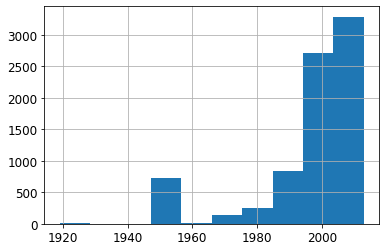

In [ ]:
ax = valid_xs_final['YearMade'].hist()

In [ ]:
#partial dependence allows us to see everything else being equal, what happens to the y when we change our feature of interent

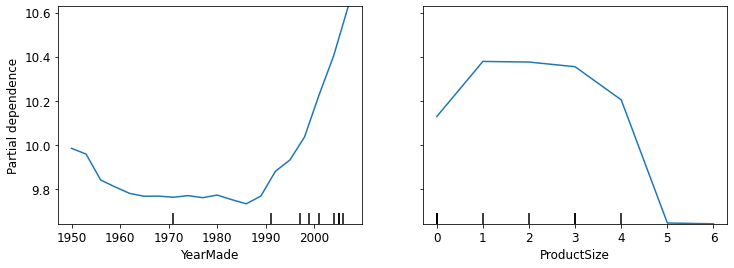

In [ ]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12,4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax)

We now can see the affect of the two feautures. It seems that for yearmade its pretty obvious new year = more expensive however for product size, the amount of NA is worrying. We need to find out why its missing so often and if the missing values indicate data leakage

### Data leakage


Data leakage is when the model is given information that can only be known after the fact an event 'sale of a product" has happened. 

Large amounts of NA can also be an sign of data leakage as for example, when trying to determine whether or not someone will be given a grant or not can be identified as only students who are accepted have certain information filled. 

In [ ]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [ ]:
row = valid_xs_final.iloc[:5]

In [ ]:
prediction, bias, contributions = treeinterpreter.predict(m, row.values)

predicition is the output given by RF, bias is the avg value of all our y's. contribution is total change from all the independent variables

In [ ]:
prediction[0], bias[0], contributions[0].sum()

(array([10.04592408]), 10.104349791046143, -0.05842570729254788)

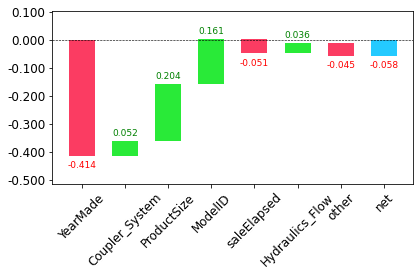

In [ ]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

### Extrapolation / out of domain data

random forest JUST avgs the predicition of a number of trees. 
A tree just predicts the avg value of a row in a leaf.
A tree thefore can never predict values outside the range of the training data , especially when there is a trend overtime. 
prediction for inflation for example will always be too low. 

Random forest cannot extrapolate from data they have not seen, so we need to make sure our validation set does not contain out of domain data

In [ ]:
## making sure our RF does not contain OOD data in validation set

df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.914005
10,SalesID,0.070536
12,MachineID,0.013131
4,ModelID,0.000414
0,YearMade,0.000376
11,Hydraulics,0.000304


In [ ]:
#dropping each column that contain OOD dta
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.233048
SalesID 0.23121
saleElapsed 0.2352
MachineID 0.231965


In [ ]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.229475

In [ ]:
#it improved accuracy and is now more robust. we should also remove old data
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [ ]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.176881, 0.229091)

sometimes just using a subset is better

In [ ]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [ ]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

if a column has more than 9000 discrete values, then it should be a continious var

In [ ]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [ ]:
cont_nn #making sure sale elapsed is continious as it will increase overtime

['saleElapsed']

In [ ]:
df_nn_final[cat_nn].nunique() # when looking at really high discrete values, we should remove a column

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Enclosure                6
fiModelDesc           5059
Hydraulics_Flow          3
Hydraulics              12
fiModelDescriptor      140
ProductGroup             6
Drive_System             4
dtype: int64

In [ ]:
#we want to drop one of the 2 columns

xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.17874, 0.229699)

In [ ]:
## so remove them from our NN
cat_nn.remove('fiModelDescriptor')

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [ ]:
dls = to_nn.dataloaders(1024)

In [ ]:
y = to_nn.train.y
y.min(),y.max() #we should add min and max for regression models

(8.465899467468262, 11.863582611083984)

In [ ]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500, 250],
                        n_out=1, loss_func=F.mse_loss) #how to we decide layers

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.00015848931798245758)

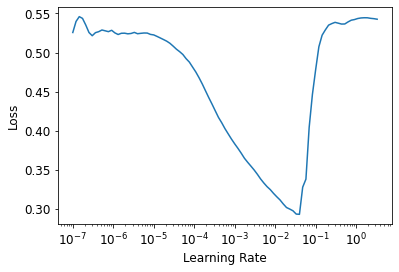

In [ ]:
learn.lr_find() #find learning rate

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.069150,0.059522,01:01
1,0.055680,0.058415,01:00
2,0.048567,0.054792,01:04
3,0.043721,0.051699,01:00
4,0.040688,0.051062,01:01


In [ ]:
preds, targs = learn.get_preds()
r_mse(preds,targs)

0.22597

In [ ]:
learn.save('nn')

Path('models/nn.pth')

In [ ]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) / 2

In [ ]:
r_mse(ens_preds, valid_y)

0.222061